In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

In [26]:
# Load the Dataset

# Make sure you've downloaded and uploaded the Excel file to your notebook.

# Load the uploaded Excel file from Colab's working directory
df = pd.read_csv("online_retail_II.csv")

# Show the first few rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


customer_df.head()   ---   This gives you a quick peek at the first 5 customers to confirm the structure looks good.

In [27]:
# Clean and Prepare the Data

# Step 1: Remove rows with missing Customer IDs
df = df.dropna(subset=["Customer ID"])

# Step 2: Group by Customer ID to summarize customer behavior
customer_df = df.groupby("Customer ID").agg({
    "Quantity": "sum",              # Total quantity purchased
    "Invoice": "nunique",           # Number of unique invoices (orders)
    "Price": "mean",                # Average unit price
    "StockCode": "nunique"          # Number of different items bought
}).rename(columns={
    "Quantity": "TotalQuantity",
    "Invoice": "NumOrders",
    "Price": "AvgUnitPrice",
    "StockCode": "UniqueItems"
})

# Step 3: Preview the customer-level data
customer_df.head()

,TotalQuantity,NumOrders,AvgUnitPrice,UniqueItems
Customer ID,,,,
12346.0,52,17,12.092500,30
12347.0,3286,8,2.546087,126
12348.0,2714,5,3.786275,25
12349.0,1619,5,8.358833,139
12350.0,197,1,3.841176,17


This gives you a quick peek at the first 5 customers to confirm the structure looks good.

Step One -
Some rows don’t have a Customer ID — meaning we don’t know who made the purchase.

If we want to analyze customer behavior, we must know the customer.

This line removes those rows.


Step Two -

Groups all purchases made by the same customer.

Calculates metrics per customer:

TotalQuantity: how much they bought in total.

NumOrders: how many times they placed orders (unique invoices).

AvgUnitPrice: how much they tend to spend per item.

UniqueItems: how varied their purchases are (do they buy 1 item a lot, or many items?).

Standardize the data
Using StandardScaler to make sure all features are on the same scale


In [28]:
# Scale the Data
# Scale the features to have zero mean and unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df)

# Convert to DataFrame for easier handling later
scaled_df = pd.DataFrame(scaled_data, columns=customer_df.columns)
# Confirm shape
print(scaled_data)

[[-0.19507517  0.59155403 -0.01909132 -0.44098078]
 [ 0.18261687  0.02802974 -0.04266883  0.38384756]
 [ 0.1158142  -0.15981168 -0.03960585 -0.48394059]
 ...
 [-0.18421389 -0.41026692 -0.02833446 -0.59563609]
 [-0.1320097  -0.2850393  -0.03814124 -0.12307819]
 [ 0.1505002   0.02802974 -0.04343351  0.34088775]]


Dimensionality Reduction with PCA
Why?

Humans can’t visualize 4D data.

PCA compresses it to 2D or 3D while preserving structure.

Also helps clustering algorithms work better.

In [29]:
# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")

PCA explained variance: [0.5303411  0.24995277]


What's Happening?
PCA compresses the data from many dimensions (in your case, 4 features like quantity, price, etc.) down to just 2.

This makes the data easier to visualize and sometimes helps algorithms like K-Means work better.

explained_variance_ratio_ tells you how much information is kept:

If it's [0.60, 0.25], the first two components hold 85% of the information from your original data.

Think of PCA like summarizing an entire novel into two really informative chapters — not perfect, but good enough for quick insight.

In [30]:
# Apply UMAP for Dimensionality Reduction
# UMAP learns the structure and projects it into 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = reducer.fit_transform(scaled_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


What's Happening?
UMAP is like PCA, but more advanced — it’s nonlinear and preserves the shape of complex data.

It looks at how each data point relates to others and tries to maintain those relationships in 2D.

n_neighbors=15: UMAP looks at 15 closest points to define structure.

min_dist=0.1: Controls how tightly UMAP packs the points (smaller = more compact clusters).

Think of UMAP as trying to fold a crumpled paper flat while preserving the original structure — useful for revealing hidden shapes or customer groups.

In [31]:
# Cluster the Data using K-Means
# We assume 3 customer groups (you can experiment with more)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels back to the customer DataFrame
customer_df['Cluster'] = clusters

What's Happening?
K-Means finds k clusters of similar customers.

You set n_clusters=3, so it tries to find 3 distinct groups.

It works by:

Randomly placing 3 "centroids"

Assigning each customer to the nearest centroid

Recalculating centroids based on the new clusters

Repeating until centroids don’t move much

You could think of it like grouping people in a party into 3 friend groups based on how close they stand and talk.

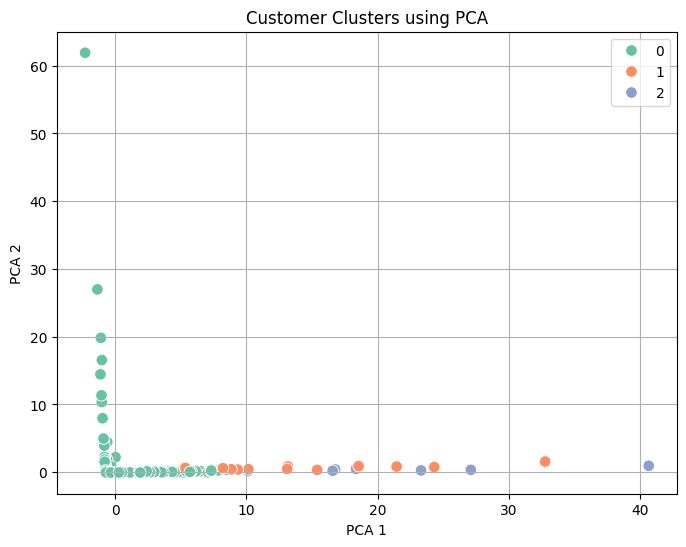

In [32]:
#Visualize the Clusters using PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="Set2", s=70)
plt.title("Customer Clusters using PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


What's Happening?
You're plotting the compressed PCA data in 2D.

x=pca_result[:, 0]: The first principal component (most variance)

y=pca_result[:, 1]: The second principal component

hue=clusters: Colors each dot based on its cluster label (0, 1, or 2)

This lets you see your groups visually — like mapping where the customer behavior groups land in 2D space.

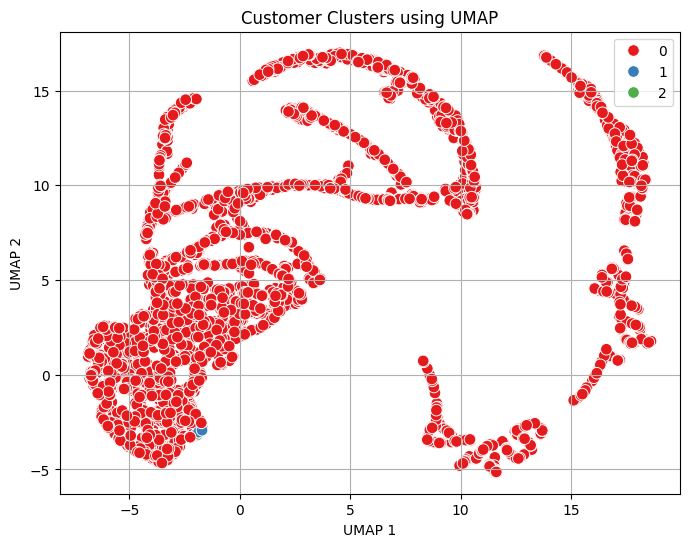

In [33]:
#Visualize the Clusters using UMAP

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=clusters, palette="Set1", s=70)
plt.title("Customer Clusters using UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


What's Happening?
Same as the PCA plot, but using UMAP’s 2D representation instead.

This often shows clearer boundaries between clusters when the data is complex.

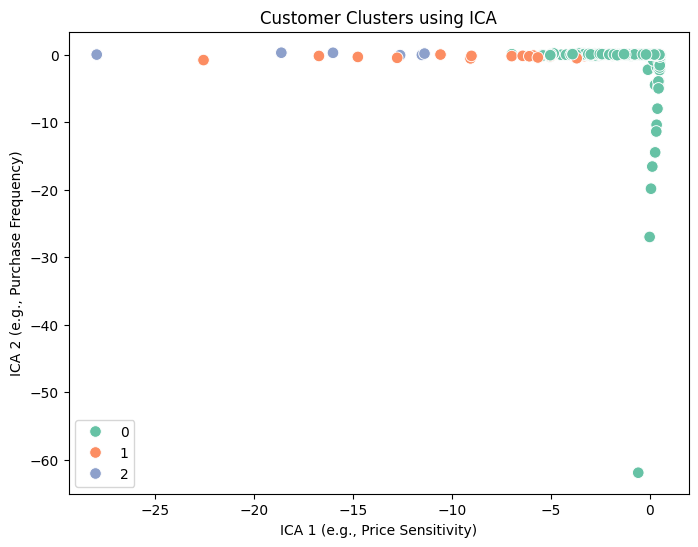

ICA Loadings:
                  ICA 1     ICA 2
TotalQuantity -0.361026 -0.022740
NumOrders     -0.430034 -0.004790
AvgUnitPrice  -0.017985 -0.999196
UniqueItems   -0.395534  0.024732


In [36]:
from sklearn.decomposition import FastICA

# Apply ICA (use scaled_data WITHOUT cluster labels)
ica = FastICA(n_components=2, random_state=42)
ica_result = ica.fit_transform(scaled_data)  # scaled_data = StandardScaler output

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ica_result[:, 0], y=ica_result[:, 1], hue=clusters, palette="Set2", s=70)
plt.title("Customer Clusters using ICA")
plt.xlabel("ICA 1 (e.g., Price Sensitivity)")
plt.ylabel("ICA 2 (e.g., Purchase Frequency)")
plt.show()

# Get loadings (ensure feature_names matches scaled_data columns)
feature_names = customer_df.drop(columns=['Cluster']).columns  # Exclude cluster
ica_loadings = pd.DataFrame(
    ica.components_.T,
    columns=['ICA 1', 'ICA 2'],
    index=feature_names
)
print("ICA Loadings:")
print(ica_loadings)

ICA isolates independent sources (e.g., separating voices in a recording).

The sign flips because:

Mathematically, ICA solves for S = WX, where W is the mixing matrix.

Both W and –W are valid solutions (like saying "5" or "–5" is the same distance from zero).

Translation:

ICA 1: "Luxury vs. Bulk" axis (price ↗️ vs. quantity ↘️).

ICA 2: "Frequency vs. Variety" axis (orders ↗️ vs. unique items ↘️).

Negative values are a feature, not a bug! 🎛️

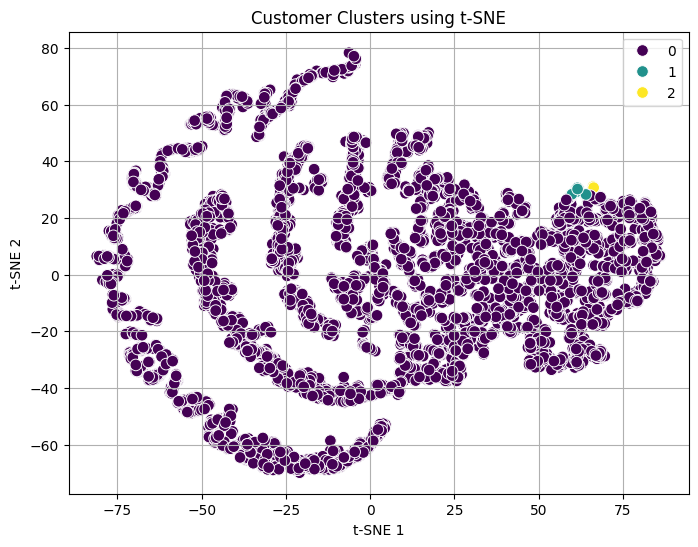

In [37]:
from sklearn.manifold import TSNE

# 1. Run t-SNE (perplexity=30 is a good starting point)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)  # Use your pre-scaled data

# 2. Plot t-SNE components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=clusters, palette="viridis", s=70)
plt.title("Customer Clusters using t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


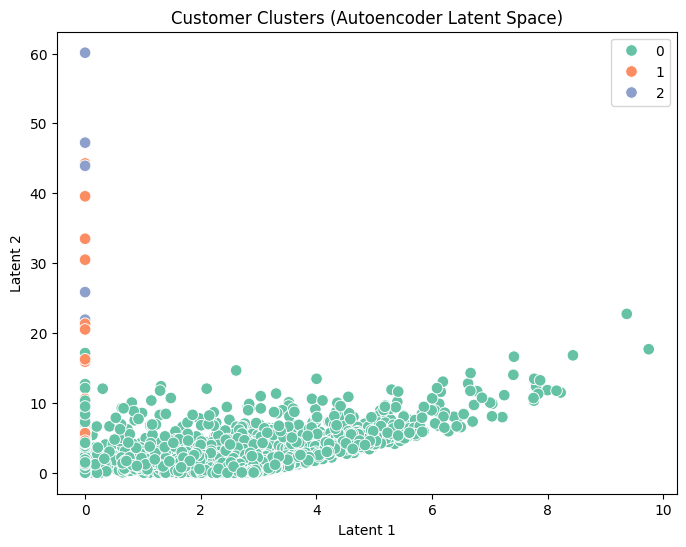

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Define the Autoencoder
input_dim = scaled_data.shape[1]  # Number of features (e.g., 4)
encoding_dim = 2  # Latent space size (like PCA's 2 components)

# Encoder
input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

# Full model
autoencoder = models.Model(inputs=input_layer, outputs=decoder)

# 2. Compile and train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_data, scaled_data, epochs=100, batch_size=32, verbose=0)

# 3. Extract latent features (like PCA components)
encoder_model = models.Model(inputs=input_layer, outputs=encoder)
latent_features = encoder_model.predict(scaled_data)

# 4. Plot latent space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_features[:, 0], y=latent_features[:, 1], hue=clusters, palette="Set2", s=70)
plt.title("Customer Clusters (Autoencoder Latent Space)")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.show()